In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.0 MB/s eta 0:00:00


In [ ]:
#!pip install tensorflow==2.11
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 25.7 MB/s eta 0:00:00


In [ ]:
import shap
print("SHAP Version : {}".format(shap.__version__))

SHAP Version : 0.41.0


In [ ]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import sklearn.model_selection as skl_ms
import seaborn as sns
import cv2
import random
from PIL import Image
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [ ]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Applied AI/quality_annotated_dataframe.csv')

In [ ]:
# unzip the dataset
!unzip "/content/drive/MyDrive/Applied AI/train.zip" -d "/content/train/"

In [ ]:
dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break

    filename = filenames[index]
    next_filename = filenames[index + 1]

    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')

    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1

dataframe_quality = dataframe_quality[to_remove == 0]

print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/content/train/train/' + dataframe_path['label'] + '/' + dataframe_path['file']

Removed 1293 duplicates


In [ ]:
def preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)

    gaussian_img = np.stack([gaussian_img for i in range(3)], axis=-1)

    scaled = tf.keras.applications.densenet.preprocess_input(gaussian_img)

    return scaled

In [ ]:
# Unzip models
!unzip "/content/drive/MyDrive/Applied AI/models/DenseNet121-withoutAug_expanded.zip" -d "/content/MedModel/"
!unzip "/content/drive/MyDrive/Applied AI/models/Q-DenseNet121-MedModel-withAug_expanded.zip" -d "/content/MedModel/"
!unzip "/content/drive/MyDrive/Applied AI/models/DenseNet169-withoutAug_expanded.zip" -d "/content/MedModel/"
!unzip "/content/drive/MyDrive/Applied AI/models/DenseNet169-withAug_expanded.zip" -d "/content/MedModel/"

In [ ]:
# Load models
model_dense121 = keras.models.load_model("/content/MedModel/kaggle/working/DenseNet121-withoutAug_expanded")
model_dense121_aug = keras.models.load_model("/content/MedModel/kaggle/working/Q-DenseNet121-MedModel-withAug_expanded")
model_dense169 = keras.models.load_model("/content/MedModel/kaggle/working/DenseNet169-withoutAug_expanded")
model_dense169_aug = keras.models.load_model("/content/MedModel/kaggle/working/DenseNet169-withAug_expanded")

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_path,
    directory='/content/train/train',
    x_col='path',
    y_col='label',
    classes=['N', 'P', 'T'],
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    data_format="channels_last",
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)

Found 10792 validated image filenames belonging to 3 classes.


In [ ]:
predictions_dense121 = model_dense121.predict(test_generator)
predictions_dense121_aug = model_dense121_aug.predict(test_generator)
predictions_dense169 = model_dense169.predict(test_generator)
predictions_dense169_aug = model_dense169_aug.predict(test_generator)


169/169 [==============================] - 331s 2s/step


In [ ]:
label_dict = {'N':0, 'P':1, 'T':2}
numerical_dict = {0:'N', 1:'P', 2:'T'}
dict_apply = lambda x: label_dict[x]

true_labels = dataframe_path['label'].apply(dict_apply).to_numpy()

prediction_numerical_dense121 = np.argmax(predictions_dense121, axis=-1)
prediction_numerical_dense121_aug = np.argmax(predictions_dense121_aug, axis=-1)
prediction_numerical_dense169 = np.argmax(predictions_dense169, axis=-1)
prediction_numerical_dense169_aug = np.argmax(predictions_dense169_aug, axis=-1)

correct_predictions_dense121 = np.array(np.where(prediction_numerical_dense121 == true_labels)).flatten()
correct_predictions_dense121_aug = np.array(np.where(prediction_numerical_dense121_aug == true_labels)).flatten()
correct_predictions_dense169 = np.array(np.where(prediction_numerical_dense169 == true_labels)).flatten()
correct_predictions_dense169_aug = np.array(np.where(prediction_numerical_dense169_aug == true_labels)).flatten()

incorrect_predictions_dense121 = np.setdiff1d(np.arange(0, true_labels.shape[0]), correct_predictions_dense121)
incorrect_predictions_dense121_aug = np.setdiff1d(np.arange(0, true_labels.shape[0]), correct_predictions_dense121_aug)
incorrect_predictions_dense169 = np.setdiff1d(np.arange(0, true_labels.shape[0]), correct_predictions_dense169)
incorrect_predictions_dense169_aug = np.setdiff1d(np.arange(0, true_labels.shape[0]), correct_predictions_dense169_aug)

In [ ]:
correct_predictions_dense121.shape, correct_predictions_dense121_aug.shape, correct_predictions_dense169.shape, correct_predictions_dense169_aug.shape

((10660,), (10223,), (10686,), (10413,))

In [ ]:
paths = dataframe_path['path'].to_numpy()


In [ ]:
# choose the class
desired_class = 2
bag_of_examples = np.array(np.where(true_labels == desired_class)).flatten() #indeces of desired


In [ ]:
current_prediction = np.random.choice(bag_of_examples, 1)[0] #index of img that we want to use(predict and analyse)
current_image = cv2.imread(paths[current_prediction], cv2.IMREAD_GRAYSCALE) # img that we want to use(predict and analyse)


original_image = cv2.resize(current_image, (512,512))
original_image = np.stack([original_image for i in range(3)], axis=-1)

print('Dense121: Current Prediction index: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense121[current_prediction], true_labels[current_prediction]))
print('Dense121_aug: Current Prediction index: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense121_aug[current_prediction], true_labels[current_prediction]))
print('Dense169: Current Prediction index: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense169[current_prediction], true_labels[current_prediction]))
print('Dense169_aug:Current Prediction index: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense169_aug[current_prediction], true_labels[current_prediction]))



Dense121: Current Prediction index: 3413, Predicted: 2, Correct: 2
Dense121_aug: Current Prediction index: 3413, Predicted: 2, Correct: 2
Dense169: Current Prediction index: 3413, Predicted: 2, Correct: 2
Dense169_aug:Current Prediction index: 3413, Predicted: 2, Correct: 2


In [ ]:
# Define a masker that is used to mask out partitions of the input image,
# blurred background
masker = shap.maskers.Image("inpaint_telea", (512,512,3))

explainer_dense121 = shap.Explainer(model_dense121, masker, output_names=["N","P","T"])
explainer_dense121_aug = shap.Explainer(model_dense121_aug, masker, output_names=["N","P","T"])
explainer_dense169 = shap.Explainer(model_dense169, masker, output_names=["N","P","T"])
explainer_dense169_aug = shap.Explainer(model_dense169_aug, masker, output_names=["N","P","T"])

  0%|          | 0/1022 [00:00<?, ?it/s]


Partition explainer: 2it [05:04, 304.43s/it]              


Dense121: Current Prediction: 3413, Predicted: 2, Correct: 2


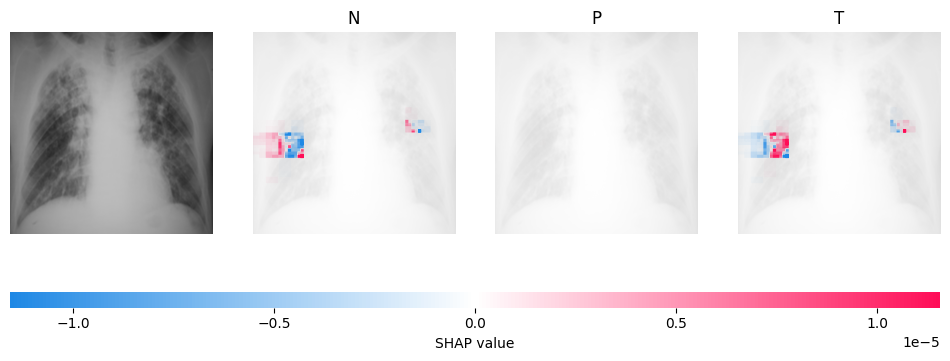

In [ ]:
#DenseNet121
shap_values = explainer_dense121(np.expand_dims(original_image, axis=0), max_evals=1024, batch_size=32, outputs=shap.Explanation.argsort.flip[:3])
print('Dense121: Current Prediction: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense121[current_prediction], true_labels[current_prediction]))
shap.image_plot(shap_values)



  0%|          | 0/1022 [00:00<?, ?it/s]


Partition explainer: 2it [02:55, 175.03s/it]              


Dense121_aug: Current Prediction: 3413, Predicted: 2, Correct: 2


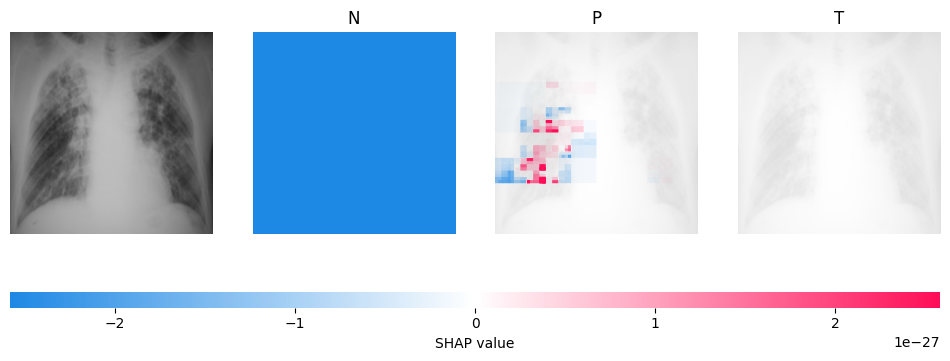

In [ ]:
#DenseNet121_aug
shap_values = explainer_dense121_aug(np.expand_dims(original_image, axis=0), max_evals=1024, batch_size=32, outputs=shap.Explanation.argsort.flip[:3])
print('Dense121_aug: Current Prediction: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense121_aug[current_prediction], true_labels[current_prediction]))
shap.image_plot(shap_values)


  0%|          | 0/1022 [00:00<?, ?it/s]


Partition explainer: 2it [03:52, 232.66s/it]              


Dense169: Current Prediction: 3413, Predicted: 2, Correct: 2


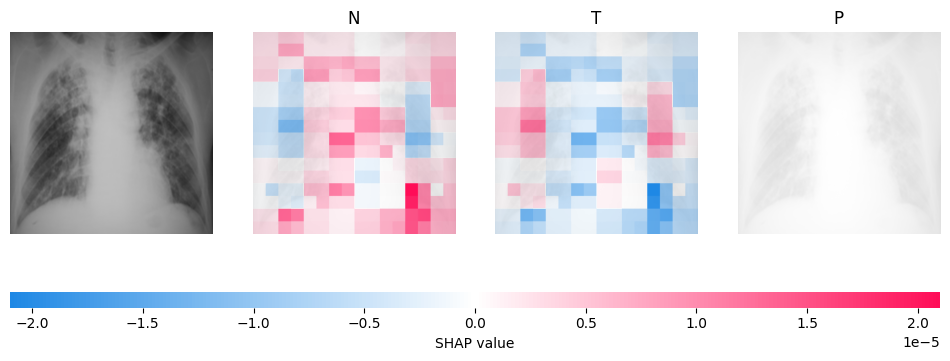

In [ ]:
#DenseNet169
shap_values = explainer_dense169(np.expand_dims(original_image, axis=0), max_evals=1024, batch_size=32, outputs=shap.Explanation.argsort.flip[:3])
print('Dense169: Current Prediction: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense169[current_prediction], true_labels[current_prediction]))
shap.image_plot(shap_values)


  0%|          | 0/1022 [00:00<?, ?it/s]


Partition explainer: 2it [04:51, 291.32s/it]              


Dense169_aug: Current Prediction: 3413, Predicted: 2, Correct: 2


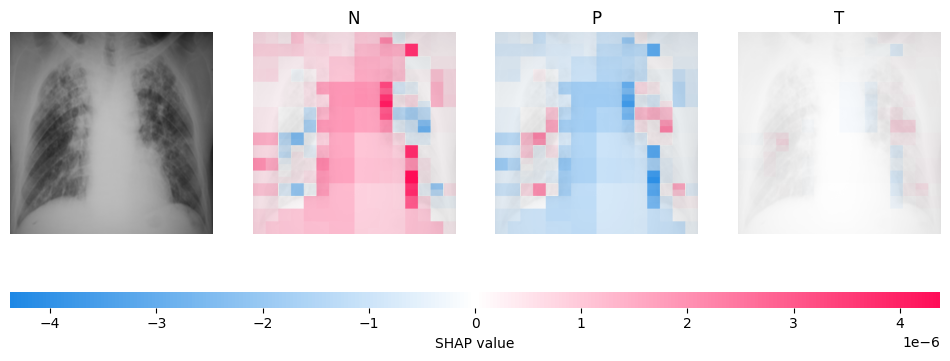

In [ ]:
#DenseNet169_aug
shap_values = explainer_dense169_aug(np.expand_dims(original_image, axis=0), max_evals=1024, batch_size=32, outputs=shap.Explanation.argsort.flip[:3])
print('Dense169_aug: Current Prediction: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical_dense169_aug[current_prediction], true_labels[current_prediction]))
shap.image_plot(shap_values)
